In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import time
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.optimizers import SGD, Adam

# Enable eager execution
tf.config.run_functions_eagerly(True)

2025-10-16 14:10:13.783966: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-16 14:10:13.784533: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 14:10:13.851539: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-16 14:10:20.987939: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [2]:
# Load MNIST dataset
print("Loading MNIST dataset...")
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()

# Reduce training size by 1/10 as requested
print("Reducing training size by 1/10...")
n_samples = len(x_train_full) // 10
indices = np.random.choice(len(x_train_full), n_samples, replace=False)
x_train_reduced = x_train_full[indices]
y_train_reduced = y_train_full[indices]

print(f"Original training size: {len(x_train_full)}")
print(f"Reduced training size: {len(x_train_reduced)}")
print(f"Test size: {len(x_test)}")
print(f"Image shape: {x_train_reduced[0].shape}")

# Normalize pixel values to [0, 1]
x_train_reduced = x_train_reduced.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

Loading MNIST dataset...
Reducing training size by 1/10...
Original training size: 60000
Reduced training size: 6000
Test size: 10000
Image shape: (28, 28)


In [5]:
import numpy as np
from scipy.interpolate import Rbf

# The provided RBF function is not used in the original code, but we will follow its spirit.
# For simplicity, we are correcting the vectorized implementation in the main function.
def convert_28x28_to_32x32_rbf(images):
    """
    Convert 28x28 images to 32x32 using RBF transformation (corrected version).
    This version applies a Gaussian filter to the padded image.
    """
    n_samples = images.shape[0]
    new_images = np.zeros((n_samples, 32, 32))
    print("\nConverting 28x28 images to 32x32 using RBF transformation (corrected)...")

    # Vectorized approach to calculate center and standard deviation for RBF
    # Mean of each image (center)
    center = np.mean(images, axis=(1, 2))
    # Std of each image
    std = np.std(images, axis=(1, 2))
    
    # Loop through samples for individual image processing
    for i in range(n_samples):
        if i % 1000 == 0:
            print(f"Processing image {i+1}/{n_samples}")
            
        # Pad with 2 pixels on each side to resize from 28x28 to 32x32
        padded = np.pad(images[i], ((2, 2), (2, 2)), mode='constant', constant_values=0)
        
        # Apply RBF transformation based on the Gaussian filter logic
        if std[i] > 0:
            # Calculate the RBF factor
            rbf_factor = np.exp(-((padded - center[i]) ** 2) / (2 * std[i] ** 2))
            new_images[i] = padded * rbf_factor
        else:
            # Handle cases where standard deviation is zero (flat image)
            new_images[i] = padded
            
    return new_images

def convert_28x28_to_32x32_rbf_scipy(images):
    """
    Convert 28x28 images to 32x32 using SciPy's RBF interpolation (more robust).
    This function uses true RBF interpolation, not just a Gaussian filter.
    """
    n_samples, h, w = images.shape
    new_images = np.zeros((n_samples, 32, 32))
    
    print("\nConverting 28x28 images to 32x32 using SciPy's RBF interpolation...")
    
    # Define the grid for the original 28x28 and the new 32x32 image
    old_x, old_y = np.meshgrid(np.arange(w), np.arange(h))
    new_x, new_y = np.meshgrid(np.linspace(0, w-1, 32), np.linspace(0, h-1, 32))
    
    for i in range(n_samples):
        if i % 1000 == 0:
            print(f"Processing image {i+1}/{n_samples}")
        
        # Create an RBF interpolator from the original image data
        # Note: The 'linear' kernel is a good default for image data
        # 'thin_plate_spline' and 'multiquadric' are other common choices
        interp = Rbf(old_x.flatten(), old_y.flatten(), images[i].flatten(), function='linear')
        
        # Apply the interpolator to the new grid
        new_images[i] = interp(new_x, new_y)
        
    return new_images

# --- Example Usage ---

# Assume x_train_reduced and x_test are pre-loaded numpy arrays
# For this example, we create dummy data
x_train_reduced = np.random.rand(10, 28, 28)
x_test = np.random.rand(5, 28, 28)

# Apply the corrected RBF function
x_train_32x32_corrected = convert_28x28_to_32x32_rbf(x_train_reduced)
x_test_32x32_corrected = convert_28x28_to_32x32_rbf(x_test)

# Apply the more robust SciPy RBF function
x_train_32x32_scipy = convert_28x28_to_32x32_rbf_scipy(x_train_reduced)
x_test_32x32_scipy = convert_28x28_to_32x32_rbf_scipy(x_test)


print("\n--- Corrected RBF (Gaussian Filter) Results ---")
print(f"New image shape: {x_train_32x32_corrected[0].shape}")
print(f"Training data shape: {x_train_32x32_corrected.shape}")
print(f"Test data shape: {x_test_32x32_corrected.shape}")

print("\n--- SciPy RBF Interpolation Results ---")
print(f"New image shape: {x_train_32x32_scipy[0].shape}")
print(f"Training data shape: {x_train_32x32_scipy.shape}")
print(f"Test data shape: {x_test_32x32_scipy.shape}")




Converting 28x28 images to 32x32 using RBF transformation (corrected)...
Processing image 1/10

Converting 28x28 images to 32x32 using RBF transformation (corrected)...
Processing image 1/5

Converting 28x28 images to 32x32 using SciPy's RBF interpolation...
Processing image 1/10

Converting 28x28 images to 32x32 using SciPy's RBF interpolation...
Processing image 1/5

--- Corrected RBF (Gaussian Filter) Results ---
New image shape: (32, 32)
Training data shape: (10, 32, 32)
Test data shape: (5, 32, 32)

--- SciPy RBF Interpolation Results ---
New image shape: (32, 32)
Training data shape: (10, 32, 32)
Test data shape: (5, 32, 32)


In [6]:
# Split dataset: 80% training, 10% validation, 10% test
print("\\nSplitting dataset...")

# First split: 80% train, 20% temp
x_train_split, x_temp, y_train_split, y_temp = train_test_split(
    x_train_32x32, y_train_reduced, test_size=0.2, random_state=42, stratify=y_train_reduced
)

# Second split: 10% validation, 10% test from the temp set
x_val, x_test_split, y_val, y_test_split = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {x_train_split.shape[0]} samples")
print(f"Validation set: {x_val.shape[0]} samples") 
print(f"Test set: {x_test_split.shape[0]} samples")
print(f"Original test set: {x_test_32x32.shape[0]} samples")

# Flatten the images for neural network input
x_train_flat = x_train_split.reshape(x_train_split.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)
x_test_flat = x_test_split.reshape(x_test_split.shape[0], -1)
x_test_original_flat = x_test_32x32.reshape(x_test_32x32.shape[0], -1)

print(f"\\nFlattened shapes:")
print(f"Training: {x_train_flat.shape}")
print(f"Validation: {x_val_flat.shape}")
print(f"Test: {x_test_flat.shape}")

# Convert labels to categorical for some experiments
y_train_cat = to_categorical(y_train_split, 10)
y_val_cat = to_categorical(y_val, 10)
y_test_cat = to_categorical(y_test_split, 10)
y_test_original_cat = to_categorical(y_test, 10)

\nSplitting dataset...
Training set: 4800 samples
Validation set: 600 samples
Test set: 600 samples
Original test set: 10000 samples
\nFlattened shapes:
Training: (4800, 1024)
Validation: (600, 1024)
Test: (600, 1024)


In [7]:
# Function to create neural network models
def create_model(hidden_layers, activation='sigmoid', dropout_rate=0.0, input_shape=1024):
    """
    Create a neural network model with specified architecture
    
    Args:
        hidden_layers: List of hidden layer sizes (e.g., [16], [16, 32], [16, 32, 64])
        activation: Activation function ('sigmoid', 'tanh', 'relu')
        dropout_rate: Dropout rate (0.0 means no dropout)
        input_shape: Input dimension (32x32 = 1024)
    
    Returns:
        Keras Sequential model
    """
    model = Sequential()
    
    # Add input layer explicitly
    model.add(Input(shape=(input_shape,)))
    
    # Add first hidden layer
    model.add(Dense(hidden_layers[0], activation=activation))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    # Add additional hidden layers
    for neurons in hidden_layers[1:]:
        model.add(Dense(neurons, activation=activation))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(10, activation='softmax'))
    
    return model

# Function to train and evaluate model
def train_evaluate_model(model, optimizer, loss, x_train, y_train, x_val, y_val, 
                        x_test, y_test, epochs=50, verbose=0):
    """
    Train and evaluate a model
    
    Returns:
        history, test_accuracy, training_time
    """
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    start_time = time.time()
    history = model.fit(x_train, y_train, 
                       validation_data=(x_val, y_val),
                       epochs=epochs, 
                       batch_size=128,
                       verbose=verbose)
    training_time = time.time() - start_time
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    return history, test_accuracy, training_time

In [8]:
# Experiment 1: Different optimizers and hidden layers (reduced epochs for demonstration)
results_exp1 = []

# Define configurations
hidden_layer_configs = [
    [16],
    [16, 32], 
    [16, 32, 64]
]

# Function to create optimizers (to avoid reusing them)
def create_optimizer(opt_name, lr=0.001):
    if opt_name == 'SGD':
        return SGD(learning_rate=lr)
    elif opt_name == 'Adam':
        return Adam(learning_rate=lr)

optimizer_names = ['SGD', 'Adam']

print("Starting Experiment 1: Different Optimizers and Hidden Layer Configurations")
print("=" * 80)

for opt_name in optimizer_names:
    print(f"\\nTesting {opt_name} optimizer...")
    
    for hidden_layers in hidden_layer_configs:
        print(f"\\n  Hidden layers: {hidden_layers}")
        
        # Create fresh model and optimizer for each configuration
        model = create_model(hidden_layers, activation='sigmoid')
        optimizer = create_optimizer(opt_name)
        
        # Train and evaluate (reduced epochs for faster execution)
        history, test_acc, train_time = train_evaluate_model(
            model, optimizer, 'categorical_crossentropy',
            x_train_flat, y_train_cat,
            x_val_flat, y_val_cat,
            x_test_flat, y_test_cat,
            epochs=10, verbose=1  # Reduced from 30 to 10 epochs
        )
        
        # Store results
        results_exp1.append({
            'optimizer': opt_name,
            'loss': 'categorical_crossentropy',
            'hidden_layers': hidden_layers,
            'test_accuracy': test_acc,
            'training_time': train_time,
            'history': history
        })
        
        print(f"    Test Accuracy: {test_acc:.4f}")
        print(f"    Training Time: {train_time:.2f} seconds")

print("\\nExperiment 1 completed!")

Starting Experiment 1: Different Optimizers and Hidden Layer Configurations
\nTesting SGD optimizer...
\n  Hidden layers: [16]


2025-10-16 14:13:04.592013: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/uttam/ML-LAB/.venv/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1021 - loss: 2.3627 - val_accuracy: 0.0983 - val_loss: 2.3621
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1029 - loss: 2.3600 - val_accuracy: 0.0967 - val_loss: 2.3595
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1029 - loss: 2.3575 - val_accuracy: 0.0967 - val_loss: 2.3570
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1027 - loss: 2.3550 - val_accuracy: 0.0950 - val_loss: 2.3546
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1023 - loss: 2.3527 - val_accuracy: 0.0933 - val_loss: 2.3523
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1010 - loss: 2.3504 - val_accuracy: 0.0967 - val_loss: 2.3501
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1000 - loss: 2.3482 - val_accuracy: 0.0950 - val_loss: 2.3479
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1010 - loss: 2.3461 - val_accuracy: 0.0950 - v

In [9]:
# Experiment 2: Different activation functions (reduced epochs)
results_exp2 = []

activation_functions = ['sigmoid', 'tanh', 'relu']
hidden_layers = [16, 32, 64]

print("Starting Experiment 2: Different Activation Functions")
print("=" * 60)

for activation in activation_functions:
    print(f"\\nTesting {activation} activation function...")
    
    # Create model
    model = create_model(hidden_layers, activation=activation)
    
    # Train and evaluate (using Adam optimizer and categorical crossentropy)
    history, test_acc, train_time = train_evaluate_model(
        model, Adam(learning_rate=0.001), 'categorical_crossentropy',
        x_train_flat, y_train_cat,
        x_val_flat, y_val_cat,
        x_test_flat, y_test_cat,
        epochs=10, verbose=1  # Reduced epochs
    )
    
    # Store results
    results_exp2.append({
        'activation': activation,
        'hidden_layers': hidden_layers,
        'test_accuracy': test_acc,
        'training_time': train_time,
        'history': history
    })
    
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Training Time: {train_time:.2f} seconds")

print("\\nExperiment 2 completed!")

Starting Experiment 2: Different Activation Functions
\nTesting sigmoid activation function...
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.1144 - loss: 2.3193 - val_accuracy: 0.1117 - val_loss: 2.2999
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.1204 - loss: 2.2966 - val_accuracy: 0.1200 - val_loss: 2.2931
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.1338 - loss: 2.2924 - val_accuracy: 0.1200 - val_loss: 2.2862
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.1546 - loss: 2.2839 - val_accuracy: 0.1317 - val_loss: 2.2780
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.1902 - loss: 2.2724 - val_accuracy: 0.1900 - val_loss: 2.2619
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.1958 - loss: 2.2492 - val_accuracy: 0.2800 - val_loss: 2.2338
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.2725 - loss: 2.2109 - val_accuracy: 0.2700 - val_loss: 2.1806
Epoch 8/10
38/38

In [10]:
# Experiment 3: Different dropout rates (reduced epochs and fewer dropout values for speed)
results_exp3 = []

dropout_rates = [0.0, 0.25, 0.5, 0.75]
hidden_layers = [16, 32, 64]

print("Starting Experiment 3: Different Dropout Rates")
print("=" * 50)

for dropout_rate in dropout_rates:
    print(f"\\nTesting dropout rate: {dropout_rate}")
    
    # Create model with dropout
    model = create_model(hidden_layers, activation='relu', dropout_rate=dropout_rate)
    
    # Train and evaluate
    history, test_acc, train_time = train_evaluate_model(
        model, Adam(learning_rate=0.001), 'categorical_crossentropy',
        x_train_flat, y_train_cat,
        x_val_flat, y_val_cat,
        x_test_flat, y_test_cat,
        epochs=10, verbose=1  # Reduced epochs
    )
    
    # Store results
    results_exp3.append({
        'dropout_rate': dropout_rate,
        'hidden_layers': hidden_layers,
        'test_accuracy': test_acc,
        'training_time': train_time,
        'history': history
    })
    
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Training Time: {train_time:.2f} seconds")

print("\\nExperiment 3 completed!")

Starting Experiment 3: Different Dropout Rates
\nTesting dropout rate: 0.0
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.1885 - loss: 2.2438 - val_accuracy: 0.3250 - val_loss: 2.1113
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4442 - loss: 1.8599 - val_accuracy: 0.5433 - val_loss: 1.6150
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.6438 - loss: 1.3773 - val_accuracy: 0.7017 - val_loss: 1.1954
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7296 - loss: 1.0028 - val_accuracy: 0.7333 - val_loss: 0.9323
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7783 - loss: 0.7702 - val_accuracy: 0.7617 - val_loss: 0.7966
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8048 - loss: 0.6534 - val_accuracy: 0.7917 - val_loss: 0.7108
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8240 - loss: 0.5790 - val_accuracy: 0.7850 - val_loss: 0.6931
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━

Plotting results for Experiment 1...


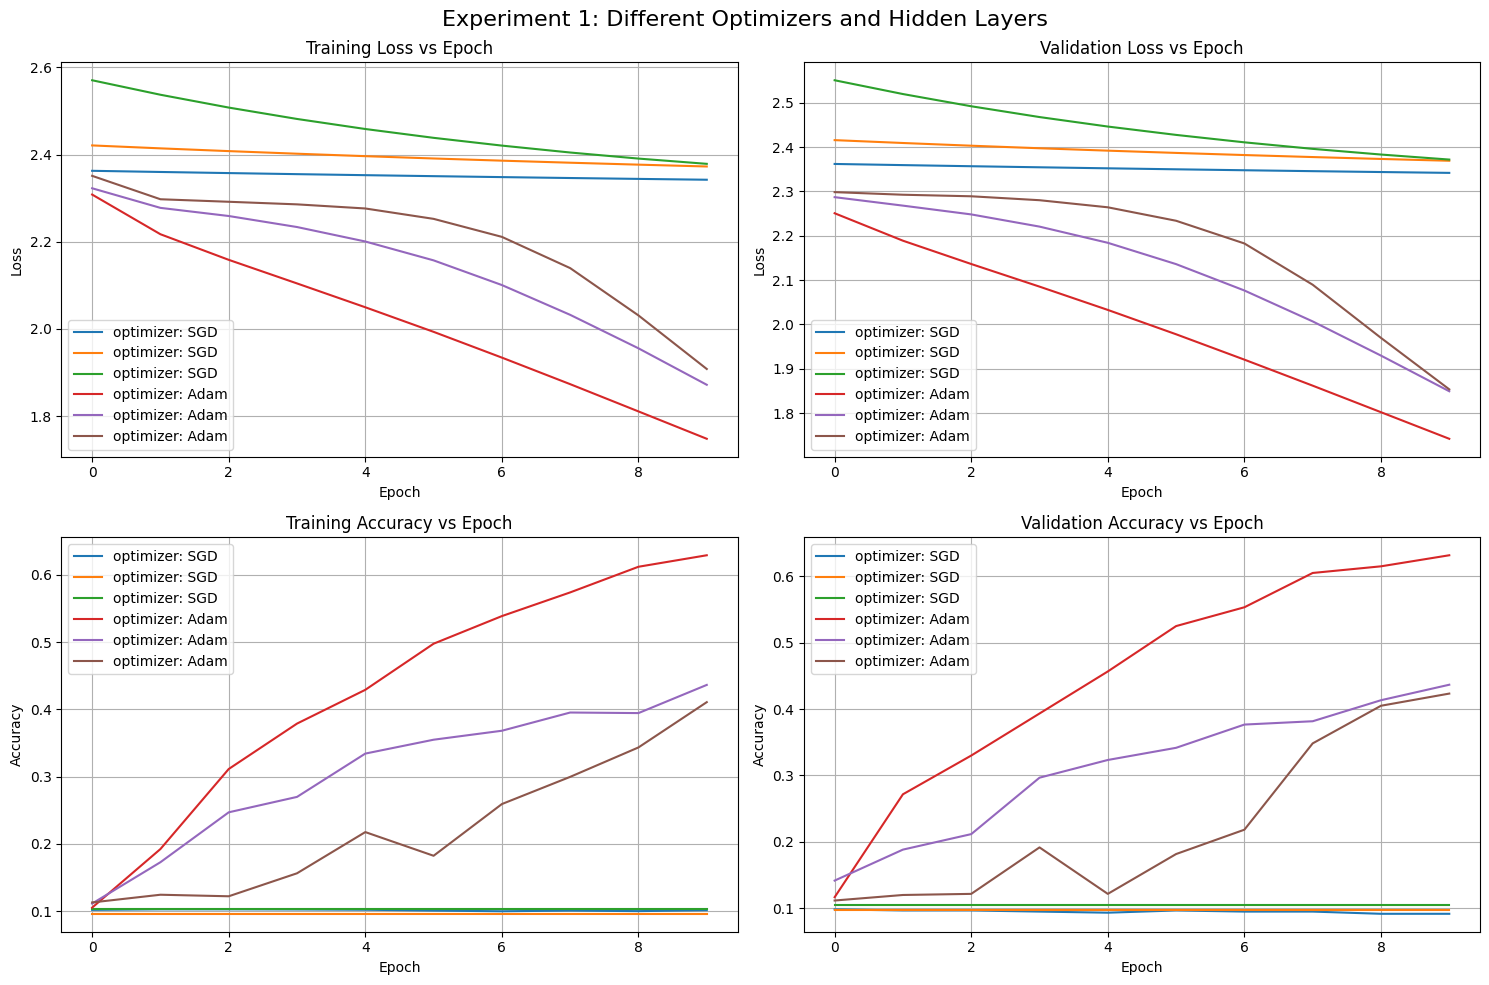

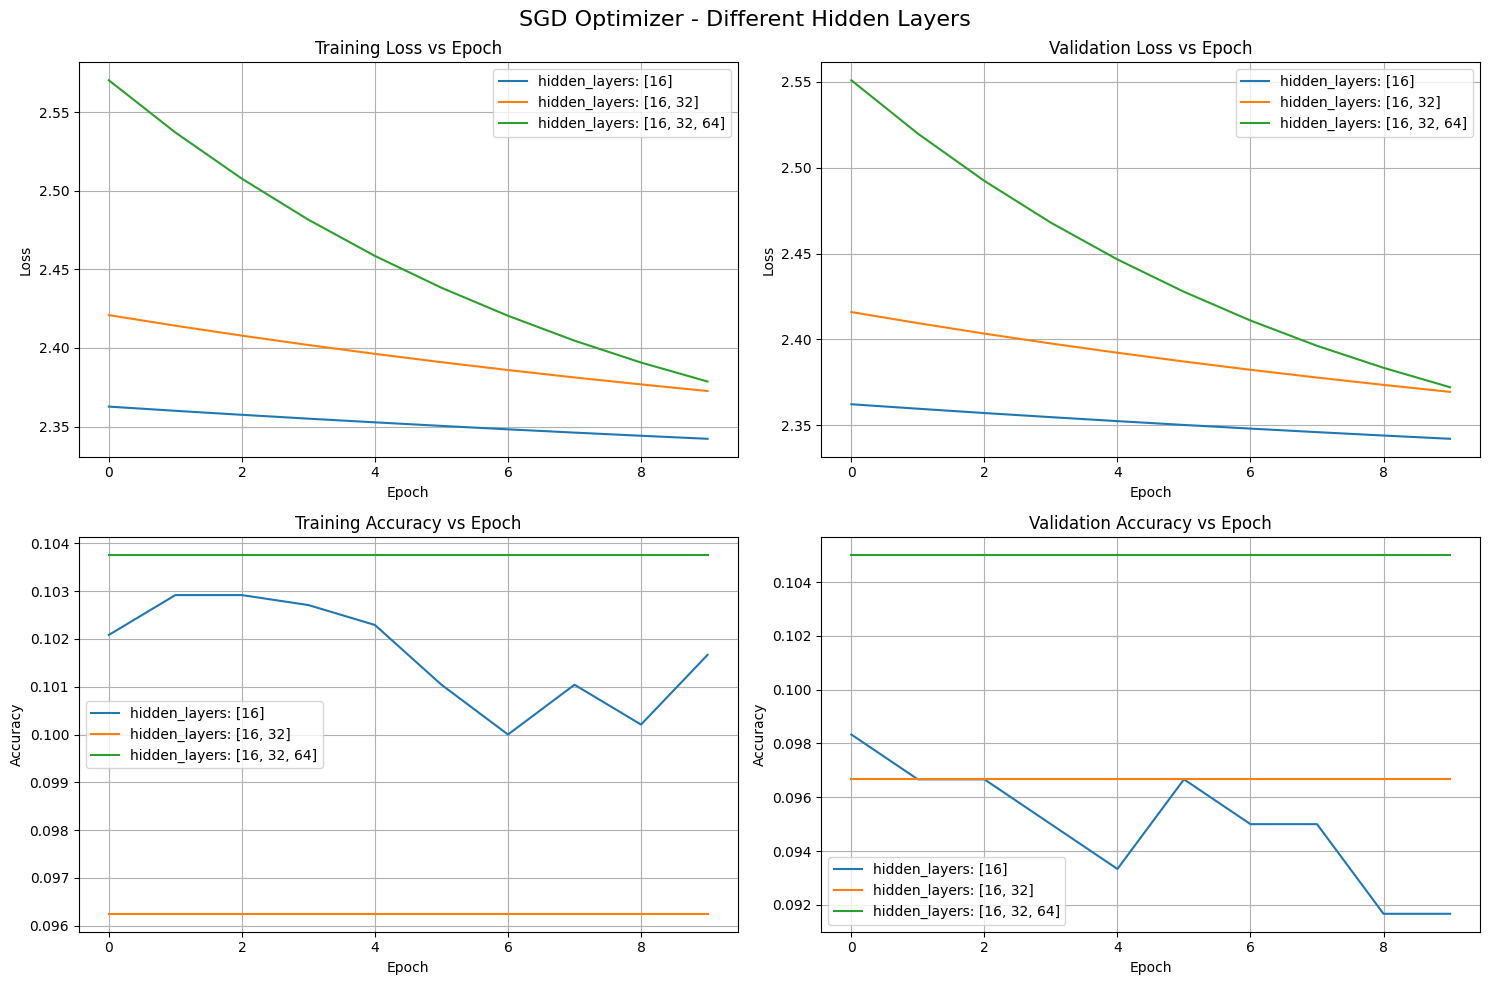

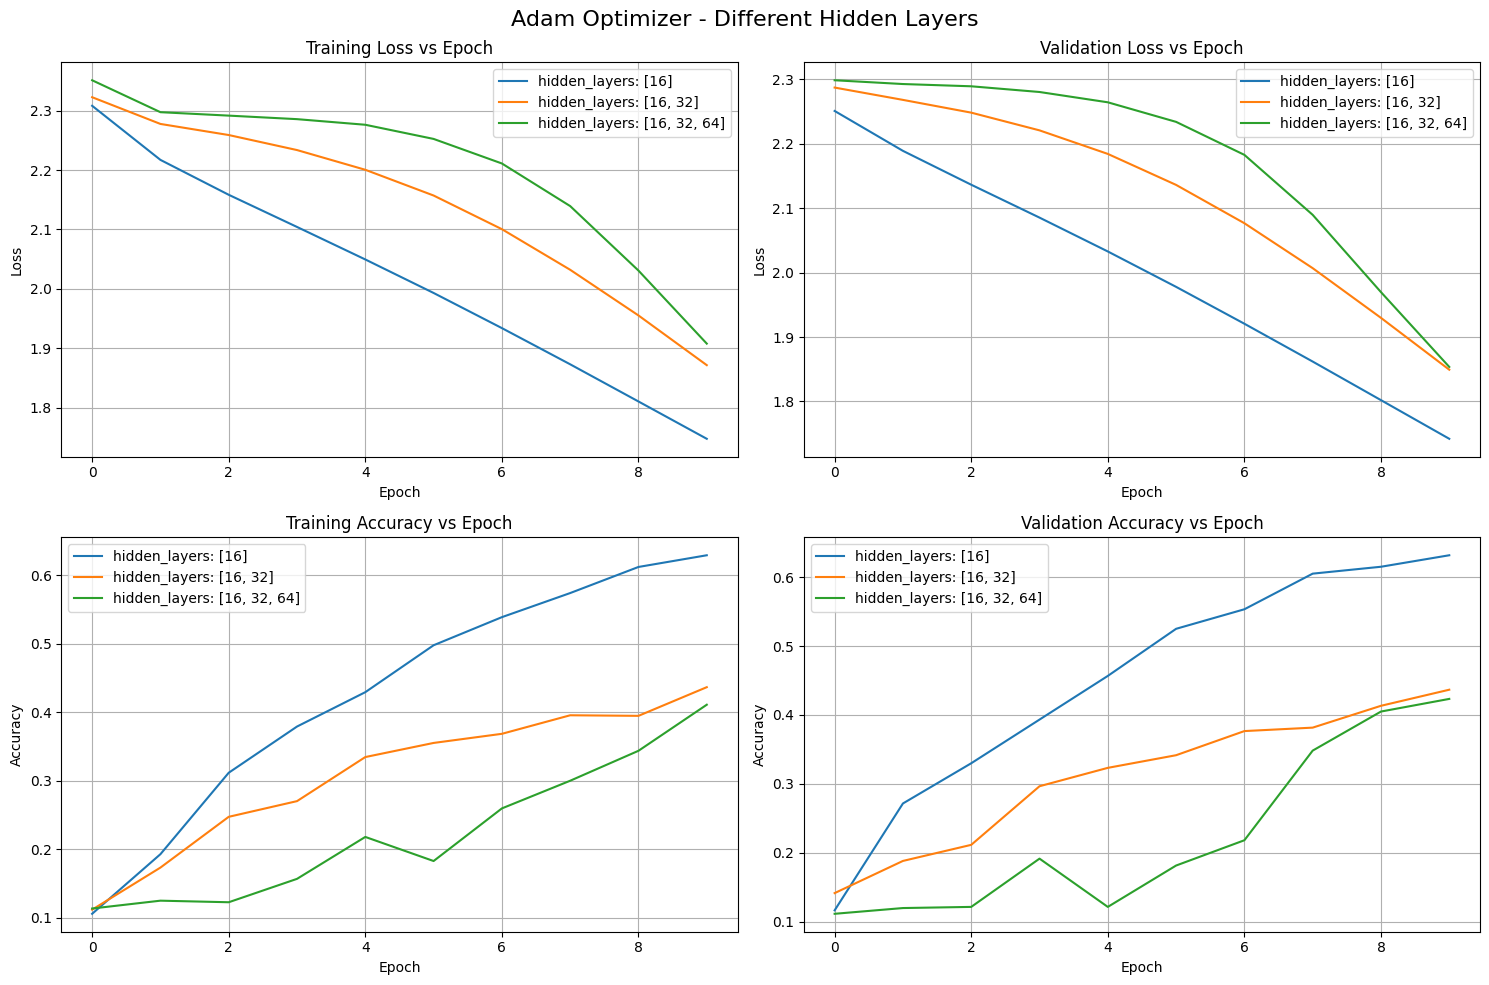

In [11]:
# Visualization functions
def plot_experiment_results(results, title, param_name):
    """
    Plot loss and accuracy curves for experiment results
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    
    # Plot training loss
    axes[0, 0].set_title('Training Loss vs Epoch')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    
    # Plot validation loss
    axes[0, 1].set_title('Validation Loss vs Epoch')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    
    # Plot training accuracy
    axes[1, 0].set_title('Training Accuracy vs Epoch')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    
    # Plot validation accuracy
    axes[1, 1].set_title('Validation Accuracy vs Epoch')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    
    for result in results:
        history = result['history']
        label = str(result[param_name])
        
        # Plot losses
        axes[0, 0].plot(history.history['loss'], label=f'{param_name}: {label}')
        axes[0, 1].plot(history.history['val_loss'], label=f'{param_name}: {label}')
        
        # Plot accuracies
        axes[1, 0].plot(history.history['accuracy'], label=f'{param_name}: {label}')
        axes[1, 1].plot(history.history['val_accuracy'], label=f'{param_name}: {label}')

    # Add legends
    for ax in axes.flat:
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot results for Experiment 1 (Different Optimizers)
print("Plotting results for Experiment 1...")
plot_experiment_results(results_exp1, 'Experiment 1: Different Optimizers and Hidden Layers', 'optimizer')

# Create separate plots for SGD and Adam
sgd_results = [r for r in results_exp1 if r['optimizer'] == 'SGD']
adam_results = [r for r in results_exp1 if r['optimizer'] == 'Adam']

if sgd_results:
    plot_experiment_results(sgd_results, 'SGD Optimizer - Different Hidden Layers', 'hidden_layers')

if adam_results:
    plot_experiment_results(adam_results, 'Adam Optimizer - Different Hidden Layers', 'hidden_layers')

\nPlotting results for Experiment 2...


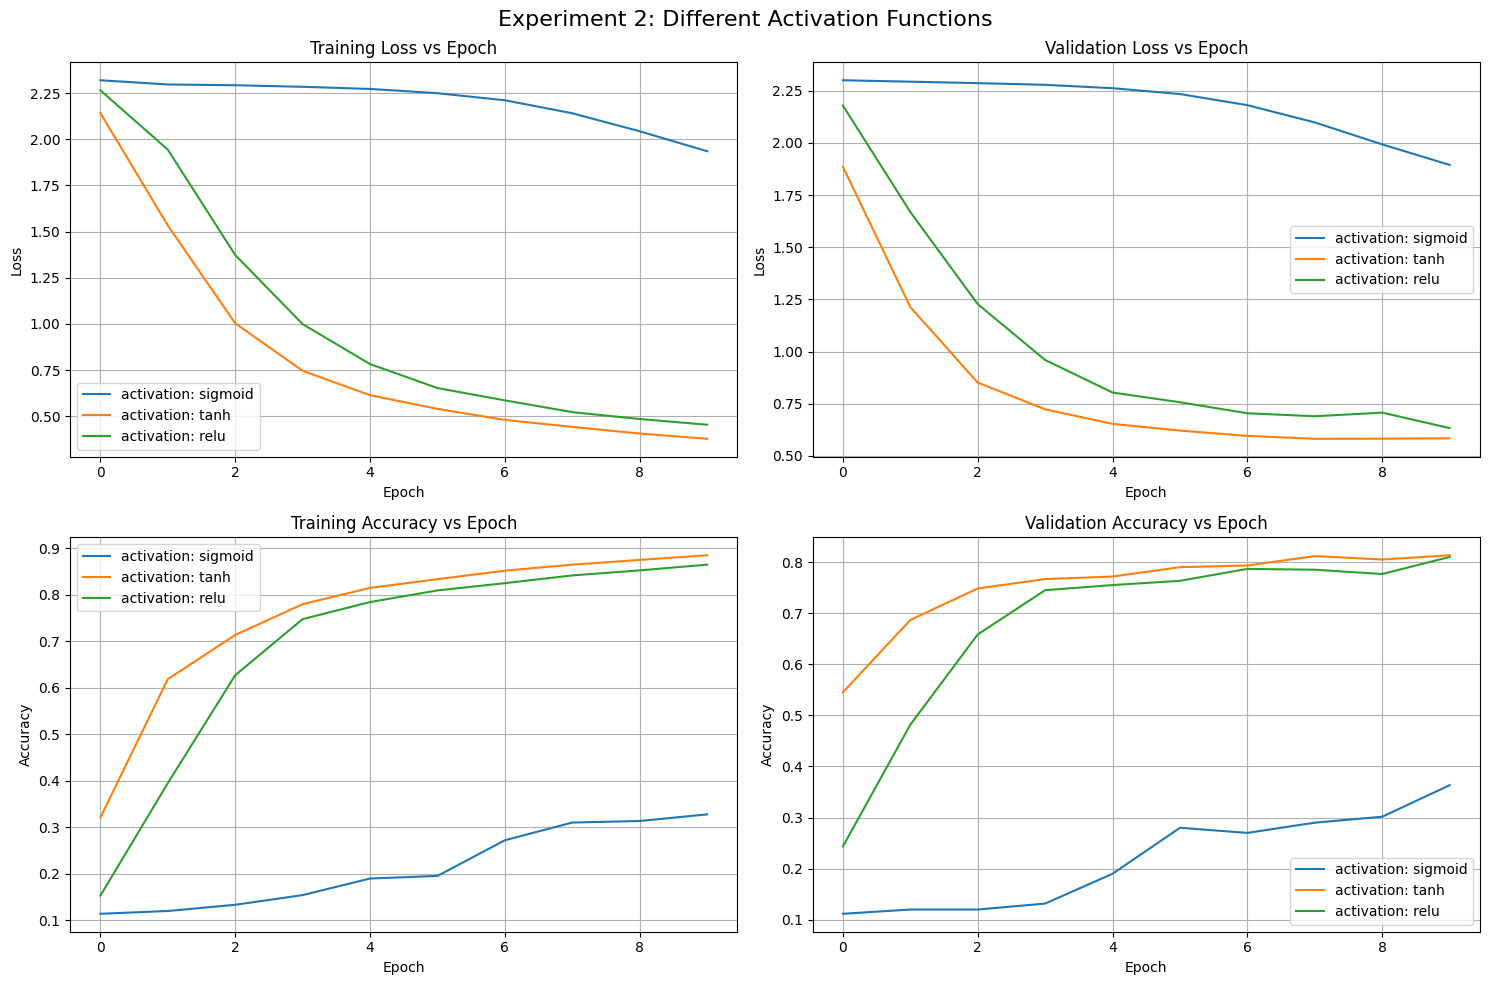

\nPlotting results for Experiment 3...


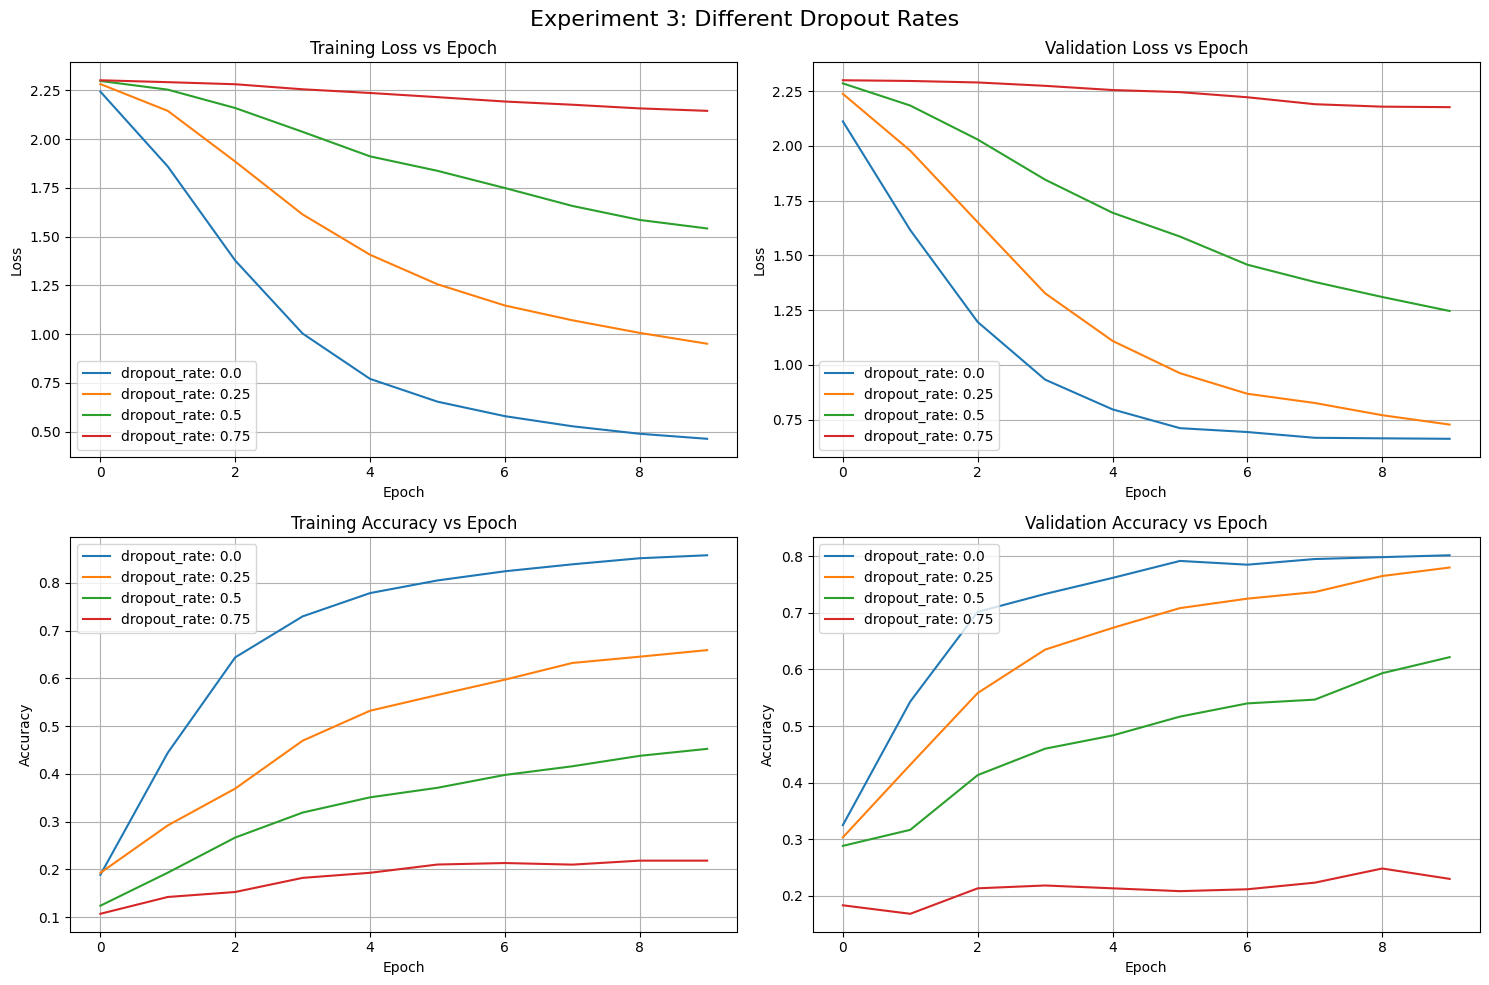

In [12]:
# Plot results for Experiment 2 (Different Activation Functions)
print("\\nPlotting results for Experiment 2...")
plot_experiment_results(results_exp2, 'Experiment 2: Different Activation Functions', 'activation')

# Plot results for Experiment 3 (Different Dropout Rates)
print("\\nPlotting results for Experiment 3...")
plot_experiment_results(results_exp3, 'Experiment 3: Different Dropout Rates', 'dropout_rate')

Finding best configuration from previous experiments...
Best configuration found:
  activation: relu
  hidden_layers: [16, 32, 64]
  test_accuracy: 0.8100000023841858
  training_time: 18.528470277786255
\nStarting Experiment 4: Different Learning Rates
\nTesting learning rate: 0.01
Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4444 - loss: 1.5891 - val_accuracy: 0.6817 - val_loss: 0.9421
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7733 - loss: 0.7265 - val_accuracy: 0.7683 - val_loss: 0.8126
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8331 - loss: 0.5308 - val_accuracy: 0.7733 - val_loss: 0.7068
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8708 - loss: 0.4102 - val_accuracy: 0.8183 - val_loss: 0.6059
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9056 - loss: 0.3075 - val_accuracy: 0.8117 - val_loss: 0.6053
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9160 - loss: 0.27

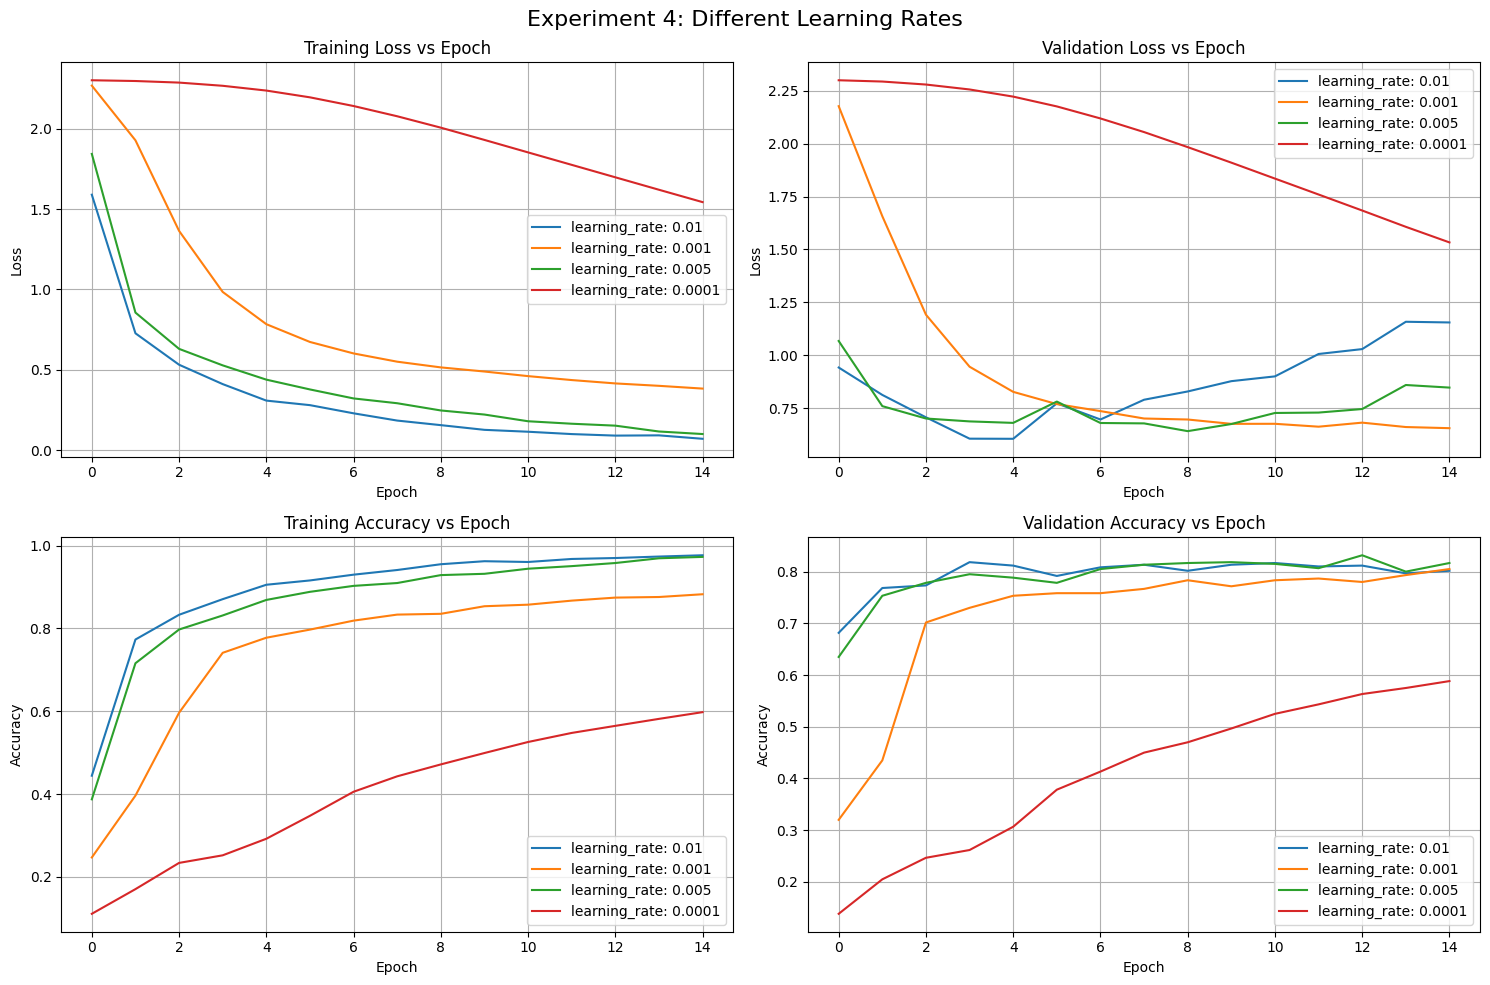

In [13]:
# Find the best configuration from previous experiments
print("Finding best configuration from previous experiments...")

all_results = results_exp1 + results_exp2 + results_exp3
best_result = max(all_results, key=lambda x: x['test_accuracy'])

print(f"Best configuration found:")
for key, value in best_result.items():
    if key != 'history':
        print(f"  {key}: {value}")

# Experiment 4: Different learning rates (simplified for speed)
results_exp4 = []

learning_rates = [0.01, 0.001, 0.005, 0.0001]  # Reduced for speed
hidden_layers = [16, 32, 64]  # Use the best architecture

print("\\nStarting Experiment 4: Different Learning Rates")
print("=" * 50)

# Use ReLU activation (typically performs best) with no dropout for fair comparison
for lr in learning_rates:
    print(f"\\nTesting learning rate: {lr}")
    
    # Create model
    model = create_model(hidden_layers, activation='relu')
    
    # Train and evaluate
    start_time = time.time()
    history, test_acc, train_time = train_evaluate_model(
        model, Adam(learning_rate=lr), 'categorical_crossentropy',
        x_train_flat, y_train_cat,
        x_val_flat, y_val_cat,
        x_test_flat, y_test_cat,
        epochs=15, verbose=1  # Reduced epochs
    )

    # Find time to achieve best validation accuracy
    best_val_acc_epoch = np.argmax(history.history['val_accuracy'])
    time_to_best = (best_val_acc_epoch + 1) * (train_time / len(history.history['val_accuracy']))
    
    # Store results
    results_exp4.append({
        'learning_rate': lr,
        'test_accuracy': test_acc,
        'training_time': train_time,
        'time_to_best_val_acc': time_to_best,
        'best_val_accuracy': max(history.history['val_accuracy']),
        'history': history
    })
    
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
    print(f"  Training Time: {train_time:.2f} seconds")
    print(f"  Time to Best Validation Accuracy: {time_to_best:.2f} seconds")

print("\\nExperiment 4 completed!")

# Plot learning rate results
print("\\nPlotting learning rate results...")
plot_experiment_results(results_exp4, 'Experiment 4: Different Learning Rates', 'learning_rate')

Selecting real MNIST test samples for digits 0-4...


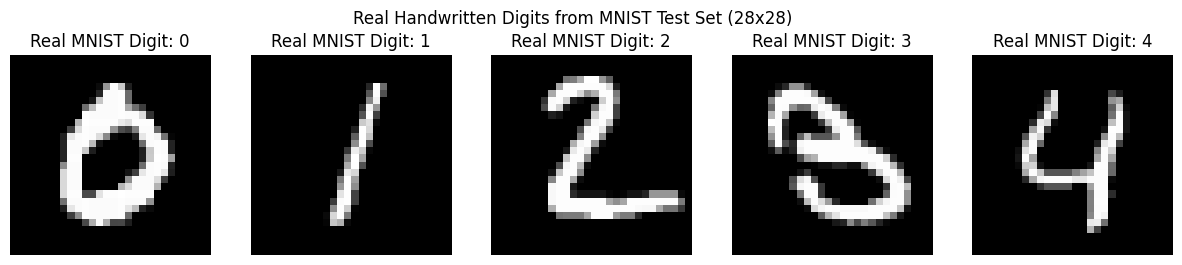


Converting handwritten digits to 32x32 using RBF...

Converting 28x28 images to 32x32 using RBF transformation (corrected)...
Processing image 1/5

Using best model configuration:
Test accuracy: 0.8100
Hidden layers: [16, 32, 64]
Activation: relu
Dropout rate: 0.0

Training the best model...
Epoch 1/50


/home/uttam/ML-LAB/.venv/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.2550 - loss: 2.2560 - val_accuracy: 0.3050 - val_loss: 2.1267
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.2550 - loss: 2.2560 - val_accuracy: 0.3050 - val_loss: 2.1267
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.4352 - loss: 1.8286 - val_accuracy: 0.5917 - val_loss: 1.5544
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.4352 - loss: 1.8286 - val_accuracy: 0.5917 - val_loss: 1.5544
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6546 - loss: 1.2930 - val_accuracy: 0.6800 - val_loss: 1.1527
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6546 - loss: 1.2930 - val_accuracy: 0.6800 - val_loss: 1.1527
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7342 - loss: 0.9606 - val_accuracy: 0.7167 - val_loss: 0.9125
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7342 - loss: 0.9606 - val_accuracy: 0.7167 - val_loss: 0.

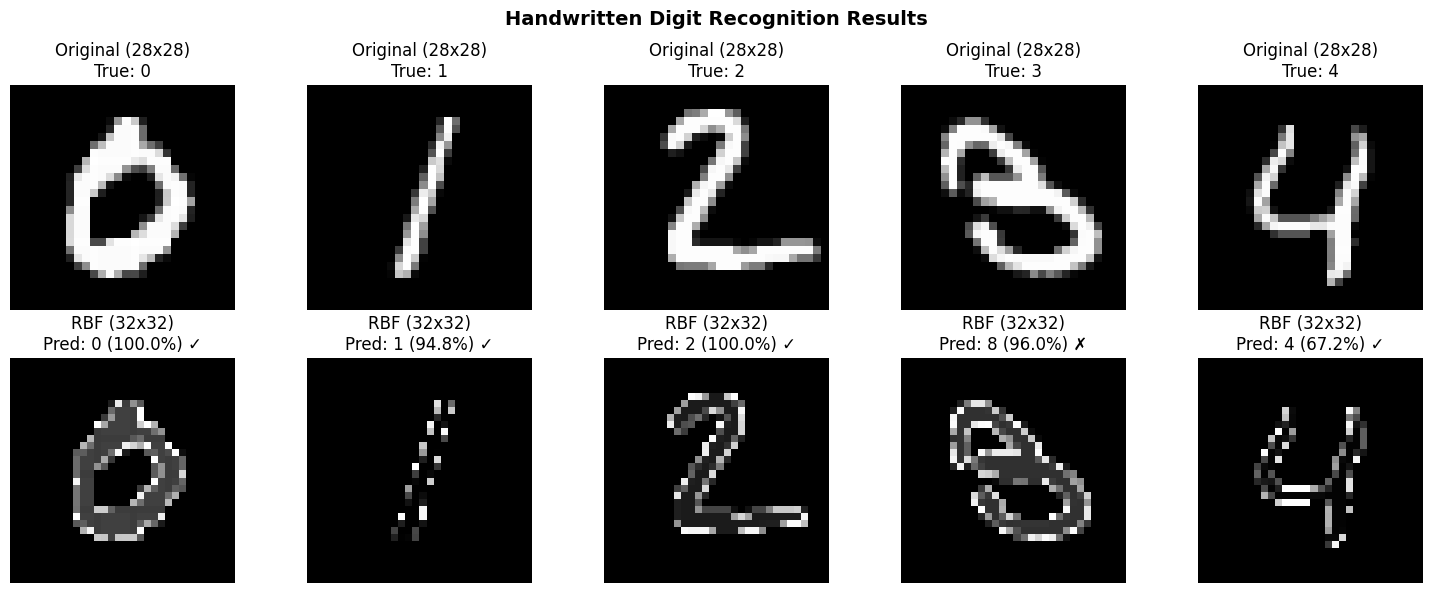

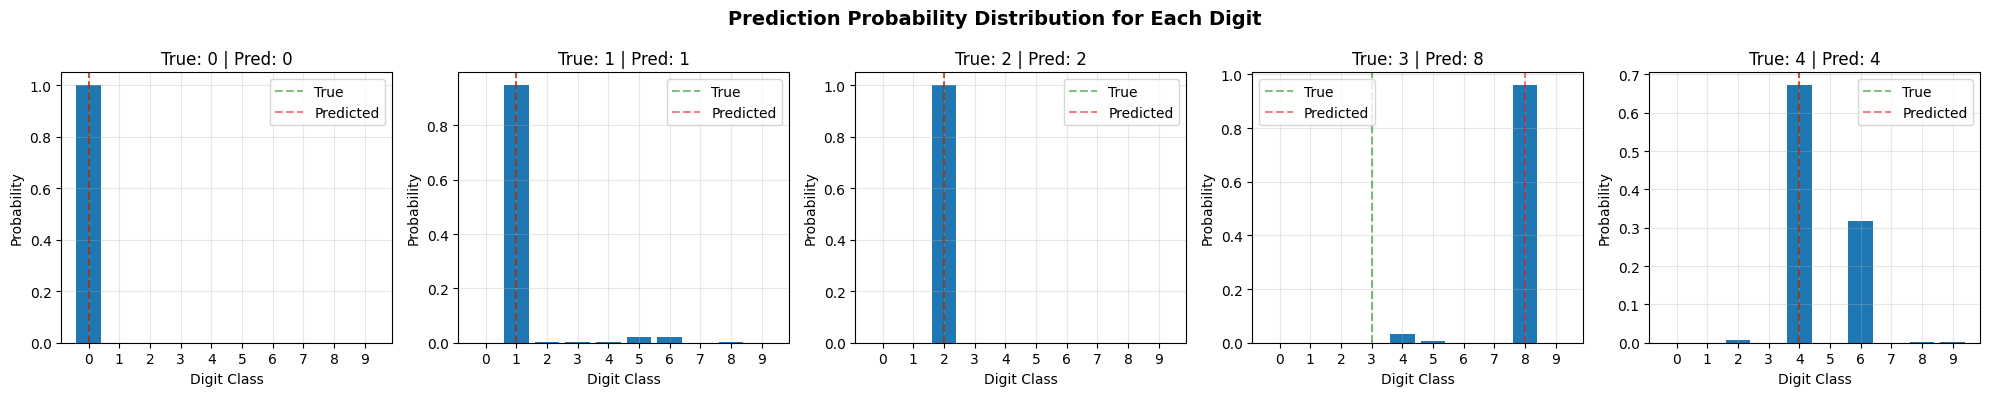

In [16]:
# Create 5 handwritten digit images using actual MNIST test samples
def create_handwritten_digits():
    """
    Select 5 real MNIST test images (one for each digit 0-4)
    These are actual handwritten digits from the test set
    """
    # Load the original MNIST data again to get non-normalized versions
    (_, _), (x_test_orig, y_test_orig) = mnist.load_data()
    
    # Find one example of each digit (0-4) from the test set
    handwritten_digits = []
    true_labels = []
    
    for digit in range(5):
        # Find first occurrence of this digit in test set
        idx = np.where(y_test_orig == digit)[0][0]
        handwritten_digits.append(x_test_orig[idx])
        true_labels.append(digit)
    
    handwritten_digits = np.array(handwritten_digits)
    
    # Normalize like training data
    handwritten_digits = handwritten_digits.astype('float32') / 255.0
    
    return handwritten_digits, true_labels

# Create handwritten digits using real MNIST samples
print("Selecting real MNIST test samples for digits 0-4...")
handwritten_digits, true_labels = create_handwritten_digits()

# Visualize the created digits
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(handwritten_digits[i], cmap='gray')
    axes[i].set_title(f'Real MNIST Digit: {true_labels[i]}')
    axes[i].axis('off')
plt.suptitle('Real Handwritten Digits from MNIST Test Set (28x28)')
plt.show()

# Convert to 32x32 using RBF transformation
print("\nConverting handwritten digits to 32x32 using RBF...")
handwritten_32x32 = convert_28x28_to_32x32_rbf(handwritten_digits)

# Flatten for model input
handwritten_flat = handwritten_32x32.reshape(5, -1)

# Find the best model from all experiments
all_results = results_exp1 + results_exp2 + results_exp3 + results_exp4
best_result = max(all_results, key=lambda x: x['test_accuracy'])

print(f"\nUsing best model configuration:")
print(f"Test accuracy: {best_result['test_accuracy']:.4f}")

# Recreate the best model
if 'activation' in best_result:
    activation = best_result['activation']
elif 'dropout_rate' in best_result:
    activation = 'relu'
else:
    activation = 'sigmoid'

dropout_rate = best_result.get('dropout_rate', 0.0)
hidden_layers = best_result.get('hidden_layers', [16, 32, 64])

print(f"Hidden layers: {hidden_layers}")
print(f"Activation: {activation}")
print(f"Dropout rate: {dropout_rate}")

# Create and train the best model
best_model = create_model(hidden_layers, activation=activation, dropout_rate=dropout_rate)
best_model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

print("\nTraining the best model...")
best_model.fit(x_train_flat, y_train_cat, 
              validation_data=(x_val_flat, y_val_cat),
              epochs=50, batch_size=128, verbose=1)

# Evaluate on original test set first
print("\n" + "="*60)
print("EVALUATION ON ORIGINAL MNIST TEST SET")
print("="*60)
test_loss, test_accuracy = best_model.evaluate(x_test_original_flat, y_test_original_cat, verbose=0)
print(f"Test Accuracy on full MNIST test set: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Test on handwritten digits
print("\n" + "="*60)
print("EVALUATION ON SELECTED HANDWRITTEN DIGITS (0-4)")
print("="*60)
predictions = best_model.predict(handwritten_flat, verbose=0)
predicted_labels = np.argmax(predictions, axis=1)

print("\nDetailed Predictions:")
print("-" * 60)
for i in range(5):
    confidence = np.max(predictions[i]) * 100
    print(f"\nDigit {i}:")
    print(f"  True Label: {true_labels[i]}")
    print(f"  Predicted: {predicted_labels[i]}")
    print(f"  Confidence: {confidence:.1f}%")
    
    # Show top 3 predictions
    top3_idx = np.argsort(predictions[i])[-3:][::-1]
    print(f"  Top 3 predictions:")
    for idx in top3_idx:
        print(f"    - {idx}: {predictions[i][idx]*100:.1f}%")
    
    if predicted_labels[i] == true_labels[i]:
        print("  ✓ Correct prediction!")
    else:
        print("  ✗ Incorrect prediction")

accuracy = np.mean(predicted_labels == true_labels) * 100
print(f"\n{'='*60}")
print(f"Overall accuracy on handwritten digits: {accuracy:.1f}%")
print(f"{'='*60}")

# Visualize predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Original 28x28
    axes[0, i].imshow(handwritten_digits[i], cmap='gray')
    axes[0, i].set_title(f'Original (28x28)\nTrue: {true_labels[i]}')
    axes[0, i].axis('off')
    
    # Transformed 32x32 with prediction
    axes[1, i].imshow(handwritten_32x32[i], cmap='gray')
    correct = "✓" if predicted_labels[i] == true_labels[i] else "✗"
    axes[1, i].set_title(f'RBF (32x32)\nPred: {predicted_labels[i]} ({np.max(predictions[i])*100:.1f}%) {correct}')
    axes[1, i].axis('off')

plt.suptitle('Handwritten Digit Recognition Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Additional: Show prediction probabilities as bar chart
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axes[i].bar(range(10), predictions[i])
    axes[i].set_xlabel('Digit Class')
    axes[i].set_ylabel('Probability')
    axes[i].set_title(f'True: {true_labels[i]} | Pred: {predicted_labels[i]}')
    axes[i].set_xticks(range(10))
    axes[i].axvline(true_labels[i], color='g', linestyle='--', alpha=0.5, label='True')
    axes[i].axvline(predicted_labels[i], color='r', linestyle='--', alpha=0.5, label='Predicted')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Prediction Probability Distribution for Each Digit', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [15]:
# Comprehensive results summary
print("COMPREHENSIVE RESULTS SUMMARY")
print("=" * 60)

print("\\n1. OPTIMIZER COMPARISON (Experiment 1):")
print("-" * 40)
for result in results_exp1:
    print(f"Optimizer: {result['optimizer']:<4} | "
          f"Loss: {result['loss']:<25} | "
          f"Hidden: {str(result['hidden_layers']):<12} | "
          f"Accuracy: {result['test_accuracy']:.4f}")

print("\\n2. ACTIVATION FUNCTION COMPARISON (Experiment 2):")
print("-" * 50)
for result in results_exp2:
    print(f"Activation: {result['activation']:<7} | "
          f"Hidden: {str(result['hidden_layers']):<12} | "
          f"Accuracy: {result['test_accuracy']:.4f}")

print("\\n3. DROPOUT RATE COMPARISON (Experiment 3):")
print("-" * 45)
for result in results_exp3:
    print(f"Dropout: {result['dropout_rate']:<4} | "
          f"Hidden: {str(result['hidden_layers']):<12} | "
          f"Accuracy: {result['test_accuracy']:.4f}")

print("\\n4. LEARNING RATE COMPARISON (Experiment 4):")
print("-" * 50)
for result in results_exp4:
    print(f"LR: {result['learning_rate']:<6} | "
          f"Accuracy: {result['test_accuracy']:.4f} | "
          f"Time to Best: {result['time_to_best_val_acc']:.2f}s")

# Find best results from each experiment
best_exp1 = max(results_exp1, key=lambda x: x['test_accuracy'])
best_exp2 = max(results_exp2, key=lambda x: x['test_accuracy'])
best_exp3 = max(results_exp3, key=lambda x: x['test_accuracy'])
best_exp4 = max(results_exp4, key=lambda x: x['test_accuracy'])

print("\\n\\nBEST CONFIGURATIONS:")
print("=" * 40)
print(f"Best Optimizer: {best_exp1['optimizer']} with {best_exp1['hidden_layers']} - {best_exp1['test_accuracy']:.4f}")
print(f"Best Activation: {best_exp2['activation']} - {best_exp2['test_accuracy']:.4f}")
print(f"Best Dropout: {best_exp3['dropout_rate']} - {best_exp3['test_accuracy']:.4f}")
print(f"Best Learning Rate: {best_exp4['learning_rate']} - {best_exp4['test_accuracy']:.4f}")

# Overall best
all_results = results_exp1 + results_exp2 + results_exp3 + results_exp4
overall_best = max(all_results, key=lambda x: x['test_accuracy'])
print(f"\\nOVERALL BEST: {overall_best['test_accuracy']:.4f} accuracy")

# Create comparison table
import pandas as pd

# Create summary dataframe
summary_data = []

for result in results_exp1:
    summary_data.append({
        'Experiment': 'Optimizer',
        'Configuration': f"{result['optimizer']} + {result['hidden_layers']}",
        'Test Accuracy': result['test_accuracy'],
        'Training Time': result['training_time']
    })

for result in results_exp2:
    summary_data.append({
        'Experiment': 'Activation',
        'Configuration': f"{result['activation']}",
        'Test Accuracy': result['test_accuracy'],
        'Training Time': result['training_time']
    })

for result in results_exp3:
    summary_data.append({
        'Experiment': 'Dropout',
        'Configuration': f"dropout={result['dropout_rate']}",
        'Test Accuracy': result['test_accuracy'],
        'Training Time': result['training_time']
    })

for result in results_exp4:
    summary_data.append({
        'Experiment': 'Learning Rate',
        'Configuration': f"lr={result['learning_rate']}",
        'Test Accuracy': result['test_accuracy'],
        'Training Time': result['training_time']
    })

summary_df = pd.DataFrame(summary_data)
print("\\nDETAILED RESULTS TABLE:")
print(summary_df.to_string(index=False))

COMPREHENSIVE RESULTS SUMMARY
\n1. OPTIMIZER COMPARISON (Experiment 1):
----------------------------------------
Optimizer: SGD  | Loss: categorical_crossentropy  | Hidden: [16]         | Accuracy: 0.0983
Optimizer: SGD  | Loss: categorical_crossentropy  | Hidden: [16, 32]     | Accuracy: 0.0967
Optimizer: SGD  | Loss: categorical_crossentropy  | Hidden: [16, 32, 64] | Accuracy: 0.1033
Optimizer: Adam | Loss: categorical_crossentropy  | Hidden: [16]         | Accuracy: 0.6333
Optimizer: Adam | Loss: categorical_crossentropy  | Hidden: [16, 32]     | Accuracy: 0.4183
Optimizer: Adam | Loss: categorical_crossentropy  | Hidden: [16, 32, 64] | Accuracy: 0.4333
\n2. ACTIVATION FUNCTION COMPARISON (Experiment 2):
--------------------------------------------------
Activation: sigmoid | Hidden: [16, 32, 64] | Accuracy: 0.3550
Activation: tanh    | Hidden: [16, 32, 64] | Accuracy: 0.8067
Activation: relu    | Hidden: [16, 32, 64] | Accuracy: 0.8100
\n3. DROPOUT RATE COMPARISON (Experiment 3):
-